### Download the Automobile data set
<b>Download link:</b> https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('Predicting the price of an automobile given a set of features') \
    .getOrCreate()

rawData = spark.read\
            .format('csv')\
            .option('header', 'true')\
            .load('../datasets/imports-85.data')

In [2]:
rawData.toPandas().head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8,115,5500,18,22,17450


#### Select the required columns
* We can select the specific features we feel are relevant in our dataset
* fields such as normalized-losses have been dropped
* The numeric fields can be cast as float or any numeric type

In [3]:
from pyspark.sql.functions import col

dataset = rawData.select(col('price').cast('float'), 
                         col('make'), 
                         col('num-of-doors'), 
                         col('body-style'), 
                         col('drive-wheels'), 
                         col('wheel-base').cast('float'), 
                         col('curb-weight').cast('float'), 
                         col('num-of-cylinders'), 
                         col('engine-size').cast('float'), 
                         col('horsepower').cast('float'), 
                         col('peak-rpm').cast('float')
                        )

In [4]:
dataset.toPandas().head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,peak-rpm
0,13495.0,alfa-romero,two,convertible,rwd,88.599998,2548.0,four,130.0,111.0,5000.0
1,16500.0,alfa-romero,two,convertible,rwd,88.599998,2548.0,four,130.0,111.0,5000.0
2,16500.0,alfa-romero,two,hatchback,rwd,94.500000,2823.0,six,152.0,154.0,5000.0
3,13950.0,audi,four,sedan,fwd,99.800003,2337.0,four,109.0,102.0,5500.0
4,17450.0,audi,four,sedan,4wd,99.400002,2824.0,five,136.0,115.0,5500.0


#### Drop columns with nulls
Check number of rows in dataset before and after removal of nulls

In [5]:
dataset.count()

205

In [6]:
dataset = dataset.replace('?', None).dropna(how='any')

In [7]:
dataset.count()

197

#### Split dataset into training and test sets

In [8]:
(trainingData, testData) = dataset.randomSplit([0.8,0.2])

#### List the categorical fields so that we can transform these to encoded values

In [9]:
categoricalFeatures = ['make',
                       'num-of-doors',
                       'body-style',
                       'drive-wheels',
                       'num-of-cylinders'
                      ]                     

#### Import and implement the required transformers

In [10]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

#### Use of handleInvalid in StringIndexer
If the model comes across a new label which it hasn't seen in the training phase, it is deemed an "invalid" label. There are different ways of handling this:
* handleInvalid='skip' will remove rows with new labels
* handleInvalid='error' will cause an error when a new label is encountered
* handleInvalid='keep' will create a new index if it encounters a new label (available from Spark 2.2 onwards)

In [11]:
indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column + '_index', 
    handleInvalid='keep') for column in categoricalFeatures]

#### One-Hot-Encode the features

In [12]:
encoders = [OneHotEncoder(
    inputCol=column + '_index', 
    outputCol= column + '_encoded') for column in categoricalFeatures]

#### List all the required features from the transformed dataset

In [13]:
requiredFeatures = ['make_encoded',
                    'num-of-doors_encoded',
                    'body-style_encoded',
                    'drive-wheels_encoded',
                    'wheel-base',
                    'curb-weight',
                    'num-of-cylinders_encoded',
                    'engine-size',
                    'horsepower',
                    'peak-rpm'
                   ]

#### Prepare the feature assembler

In [14]:
assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

#### Linear Regression



By setting α properly, elastic net contains both L1 and L2 regularization as special cases. 
* If the elasticNetParam α is set to 1, it is equivalent to a Lasso model
* If α is set to 0, the trained model reduces to a ridge regression model

regParam is the regularization variable

In [15]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=100,
                      regParam=1.0,
                      elasticNetParam=0.8,
                      labelCol='price', 
                      featuresCol='features')

#### Define our pipeline
It contains all our transformers plus the model

In [16]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

In [17]:
model = pipeline.fit(trainingData)
model

PipelineModel_49f0ae12187a4046a01f

### Extract the model from the pipeline
* Our LinearRegression model is not the same as the pipeline model
* To extract the LinearRegression model, we get it from the last stage of our pipeline model

In [18]:
lrModel = model.stages[-1]

In [19]:
print('Training RMSE = ', lrModel.summary.rootMeanSquaredError)
print('Training R^2 score = ', lrModel.summary.r2)

Training RMSE =  1749.1472953287612
Training R^2 score =  0.951275192877291


#### Check the number of features
The number will be high as many of our features are one-hot-encoded

In [20]:
lrModel.numFeatures

41

#### View the coefficients of each feature

In [21]:
lrModel.coefficients

DenseVector([-2640.5569, -2126.4838, -215.2164, -815.444, -2144.6264, -1175.3533, 1924.428, -1485.2845, 2338.74, -2324.8107, -1300.1086, 113.5838, -1449.1014, 7281.2505, 10063.6475, 11499.0064, -2363.8978, -1232.711, 9079.8242, -3815.6723, -128.6083, 128.6083, 117.4374, -308.9281, -321.649, 399.1475, 4623.7593, -80.0208, 192.1126, -468.3145, 114.551, 4.408, -1677.5112, 1696.9587, 270.4592, -849.5102, -494.352, 17124.4998, -43.3202, 74.9697, -1.5225])

#### There is a coefficient for each feature

In [22]:
len(lrModel.coefficients)

41

#### Get predictions using our model on the test data

In [23]:
predictions = model.transform(testData)
predictionsDF = predictions.toPandas()
predictionsDF.head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,...,body-style_index,drive-wheels_index,num-of-cylinders_index,make_encoded,num-of-doors_encoded,body-style_encoded,drive-wheels_encoded,num-of-cylinders_encoded,features,prediction
0,5389.0,mitsubishi,two,hatchback,fwd,93.699997,1918.0,four,92.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",5116.811706
1,6488.0,toyota,four,hatchback,fwd,95.699997,2015.0,four,92.0,62.0,...,1.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5636.295591
2,6575.0,chevrolet,four,sedan,fwd,94.500000,1909.0,four,90.0,70.0,...,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6638.678334
3,6692.0,dodge,four,sedan,fwd,93.699997,1989.0,four,90.0,68.0,...,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6530.085987
4,6849.0,nissan,four,sedan,fwd,94.500000,1938.0,four,97.0,69.0,...,0.0,0.0,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5799.032333


#### The features have been transformed to LibSVM format

In [24]:
predictionsDF['features'][0]

SparseVector(41, {4: 1.0, 21: 1.0, 23: 1.0, 27: 1.0, 30: 93.7, 31: 1918.0, 32: 1.0, 38: 92.0, 39: 68.0, 40: 5500.0})

### Use RegressionEvaluator to evaluate the model
* MulticlassClassificationEvaluator is used for classification models
* RegressionEvaluator needed to evaluate regression models
* <b>metricName </b>can be r2, rmse, mse or mae (mean absolute error)

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='r2')

r2 = evaluator.evaluate(predictions)
print('Test R^2 score = ', r2)

Test R^2 score =  0.8089306199829704


In [26]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = evaluator.evaluate(predictions)
print('Test RMSE = ', rmse)

Test RMSE =  3547.9817527786845


#### Compare the actual and predicted values of price

In [27]:
predictionsPandasDF = predictions.select(
    col('price'),
    col('prediction')
).toPandas()

In [28]:
predictionsPandasDF.head()

,price,prediction
0,5389.0,5116.811706
1,6488.0,5636.295591
2,6575.0,6638.678334
3,6692.0,6530.085987
4,6849.0,5799.032333


#### Plot a graph of actual and predicted values of price
Note that our predictions dataset is sorted in ascending order of price

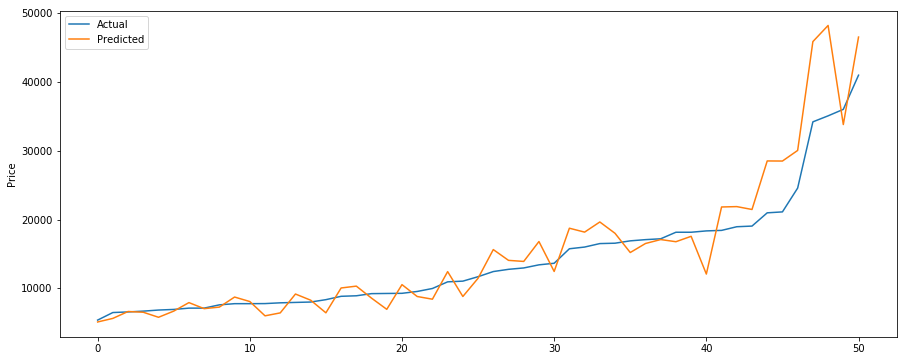

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

plt.plot(predictionsPandasDF['price'], label='Actual')
plt.plot(predictionsPandasDF['prediction'], label='Predicted')

plt.ylabel('Price')
plt.legend()

plt.show()


### Using ParamGrid for hyperparameter tuning
The parameters we wish to tweak are:
* maxIter
* regParam
* elasticNetParam - whether a lasso or ridge model will be best

In [30]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder().addGrid(
    lr.maxIter, [10,50,100]).addGrid(
    lr.regParam, [0.1, 0.3, 1.0]).addGrid(
    lr.elasticNetParam, [0.0, 1.0]).build()

#### Define the RegressionEvaluator used to evaluate the models
We wish to minimize RMSE

In [31]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

### Define the CrossValidator
This is used to put all the pieces together
* <b>estimator: </b>Can be a standalone estimator or a pipeline with an estimator at the end. We use our pipeline
* <b>estimatorParamMaps: </b>We add our paramGrid in order to build models with different combinations of the parameters
* <b>evaluator: </b>To evaluate each model, we specify our evaluator

In [32]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

#### Train each of our models with the training data
After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset

In [33]:
model = crossval.fit(trainingData)

#### To examine our best model, we extract it from the pipeline

In [34]:
lrModel = model.bestModel.stages[-1]
lrModel

LinearRegression_4a619412d45b3fd00f37

#### Get the values of the "best" parameters
Unfortunately, extracting these values is a bit awkward as we need to access the \_java\_obj object 

In [35]:
print('maxIter=', lrModel._java_obj.getMaxIter())
print('elasticNetParam=', lrModel._java_obj.getElasticNetParam())
print('regParam=', lrModel._java_obj.getRegParam())

maxIter= 10
elasticNetParam= 1.0
regParam= 1.0


#### Make predictions using our "best" model

In [36]:
predictions = model.transform(testData)
predictionsDF = predictions.toPandas()
predictionsDF.head()

,price,make,num-of-doors,body-style,drive-wheels,wheel-base,curb-weight,num-of-cylinders,engine-size,horsepower,...,body-style_index,drive-wheels_index,num-of-cylinders_index,make_encoded,num-of-doors_encoded,body-style_encoded,drive-wheels_encoded,num-of-cylinders_encoded,features,prediction
0,5389.0,mitsubishi,two,hatchback,fwd,93.699997,1918.0,four,92.0,68.0,...,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",5769.768210
1,6488.0,toyota,four,hatchback,fwd,95.699997,2015.0,four,92.0,62.0,...,1.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5770.223618
2,6575.0,chevrolet,four,sedan,fwd,94.500000,1909.0,four,90.0,70.0,...,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7085.863776
3,6692.0,dodge,four,sedan,fwd,93.699997,1989.0,four,90.0,68.0,...,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6334.606374
4,6849.0,nissan,four,sedan,fwd,94.500000,1938.0,four,97.0,69.0,...,0.0,0.0,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6176.198582


#### Evaluate the model on it's R-square score and RMSE

In [37]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='r2')

rsquare = evaluator.evaluate(predictions)
print("Test R^2 score = %g" % rsquare)

Test R^2 score = 0.863197


In [38]:
evaluator = RegressionEvaluator(
    labelCol='price', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = evaluator.evaluate(predictions)
print('Test RMSE = ', rmse)

Test RMSE =  3002.1614467956647


#### Compare actual and predicted values of price

In [39]:
predictionsPandasDF = predictions.select(
    col('price'),
    col('prediction')).toPandas()

predictionsPandasDF.head()

,price,prediction
0,5389.0,5769.768210
1,6488.0,5770.223618
2,6575.0,7085.863776
3,6692.0,6334.606374
4,6849.0,6176.198582


#### Perform the comparison using a graph

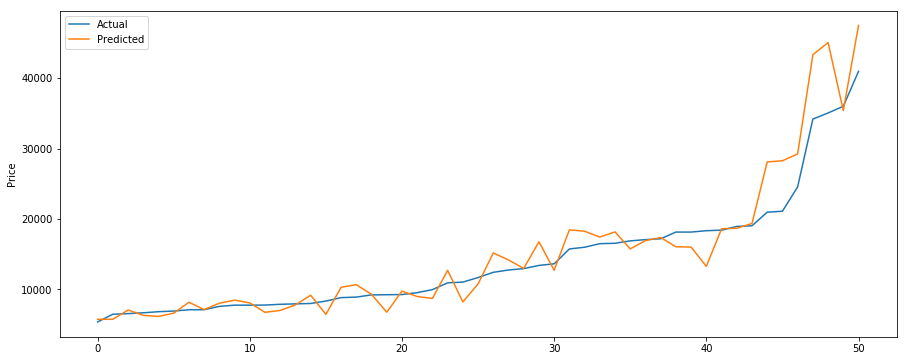

In [40]:
plt.figure(figsize=(15,6))

plt.plot(predictionsPandasDF['price'], label='Actual')
plt.plot(predictionsPandasDF['prediction'], label='Predicted')

plt.ylabel('Price')
plt.legend()

plt.show()